# 1. Import Libraries

In [ ]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


# 2. Load Data from BigQuery

In [ ]:
client = bigquery.Client()

project_id = 'youtube-content-optimize'
dataset_id = 'streaming_data'
table_id = 'youtube_video_stats'

query = f"""
    SELECT *
    FROM `{project_id}.{dataset_id}.{table_id}`
"""

try:
    df = client.query(query).to_dataframe()
    print(f"Successfully loaded {len(df)} rows into a DataFrame.")
except Exception as e:
    print(f"Error: {e}")


Successfully loaded 200 rows into a DataFrame.


# 3. Data Cleaning & Preprocessing

In [ ]:
# Convert timestamps and compute age
today = pd.to_datetime('today').tz_localize(None)
df['publishedAt'] = pd.to_datetime(df['published_at'], errors='coerce').dt.tz_localize(None)
df['days_since_published'] = (today - df['publishedAt']).dt.days

df['channel_published_at'] = pd.to_datetime(df['channel_published_at'], errors='coerce').dt.tz_localize(None)
df['channel_age_days'] = (today - df['channel_published_at']).dt.days
df['channel_age_days'] = df['channel_age_days'].replace(0, np.nan)
df['video_count'] = df['video_count'].replace(0, np.nan)


# 4. Feature Engineering

In [ ]:
def compute_metrics(df):
    df['subscriber_growth_rate'] = df['subscriber_count'] / df['channel_age_days']
    df['upload_frequency'] = df['video_count'] / df['channel_age_days']
    df['views_per_upload'] = df['view_count'] / df['video_count']
    df['engagement_per_upload'] = (df['like_count'] + df['comment_count']) / df['video_count']
    df['subscriber_per_upload'] = df['subscriber_count'] / df['video_count']
    return df

df = compute_metrics(df)


# 5. Log Transformations

In [ ]:
df['log_view_count'] = np.log1p(df['view_count'])
df['log_duration_seconds'] = np.log1p(df['duration_seconds'])
df['log_subscriber_growth_rate'] = np.log1p(df['subscriber_growth_rate'])
df['log_upload_frequency'] = df['upload_frequency']
df['log_views_per_upload'] = np.log1p(df['views_per_upload'])
df['log_engagement_per_upload'] = np.log1p(df['engagement_per_upload'])
df['log_subscriber_per_upload'] = np.log1p(df['subscriber_per_upload'])
df['log_upload_x_engagement'] = df['log_upload_frequency'] * df['log_engagement_per_upload']
df['log_upload_freq_squared'] = df['log_upload_frequency'] ** 2


# 6. Regression Modeling

In [ ]:
features = [
    'log_view_count', 'log_duration_seconds', 'log_subscriber_per_upload',
    'log_upload_frequency', 'log_views_per_upload', 'log_engagement_per_upload',
    'log_upload_x_engagement', 'log_upload_freq_squared'
]
X = df[features].dropna()
y = df.loc[X.index, 'log_subscriber_growth_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': RidgeCV(alphas=[0.01, 0.1, 1, 10]),
    'Lasso Regression': LassoCV(cv=3, random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42)
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results.append({'Model': name, 'R²': r2, 'RMSE': rmse})

results_df = pd.DataFrame(results).sort_values(by='R²', ascending=False)
print(results_df)


               Model        R²      RMSE
0  Linear Regression  0.909437  0.461888
1   Ridge Regression  0.901537  0.481611
2   Lasso Regression  0.890786  0.507224
3      Random Forest  0.579655  0.995092


In [ ]:
# Fit model
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

# Get feature names and coefficients
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lin_model.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Display intercept and coefficients
print(f"Intercept: {lin_model.intercept_}")
print(coef_df)


Intercept: -5.527120473678909
                     Feature  Coefficient
2  log_subscriber_per_upload     1.037413
0             log_view_count     0.504502
4       log_views_per_upload    -0.481601
3       log_upload_frequency     0.474185
6    log_upload_x_engagement     0.312302
1       log_duration_seconds     0.048241
5  log_engagement_per_upload    -0.029597
7    log_upload_freq_squared    -0.026600


Switch log_subscriber_growth_rate and log_view_count

In [ ]:
features = [
    'log_subscriber_growth_rate', 'log_duration_seconds', 'log_subscriber_per_upload',
    'log_upload_frequency', 'log_views_per_upload', 'log_engagement_per_upload',
    'log_upload_x_engagement', 'log_upload_freq_squared'
]
X = df[features].dropna()
y = df.loc[X.index, 'log_view_count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': RidgeCV(alphas=[0.01, 0.1, 1, 10]),
    'Lasso Regression': LassoCV(cv=3, random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42)
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results.append({'Model': name, 'R²': r2, 'RMSE': rmse})

results_df = pd.DataFrame(results).sort_values(by='R²', ascending=False)
print(results_df)


               Model        R²      RMSE
2   Lasso Regression  0.513267  0.620198
1   Ridge Regression  0.507405  0.623922
0  Linear Regression  0.506156  0.624712
3      Random Forest -0.049750  0.910810


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006363725329756598, tolerance: 0.000608367421946317
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006596299171155451, tolerance: 0.000608367421946317
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006734042483929059, tolerance: 0.000608367421946317
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.p

In [ ]:
# Fit model
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

# Get feature names and coefficients
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lin_model.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Display intercept and coefficients
print(f"Intercept: {lin_model.intercept_}")
print(coef_df)

Intercept: 12.59147933891735
                      Feature  Coefficient
3        log_upload_frequency    -1.006327
2   log_subscriber_per_upload    -0.614252
0  log_subscriber_growth_rate     0.458787
4        log_views_per_upload     0.400991
6     log_upload_x_engagement     0.151177
7     log_upload_freq_squared     0.115777
5   log_engagement_per_upload    -0.050906
1        log_duration_seconds    -0.012118


# 7. Visualize Predictions

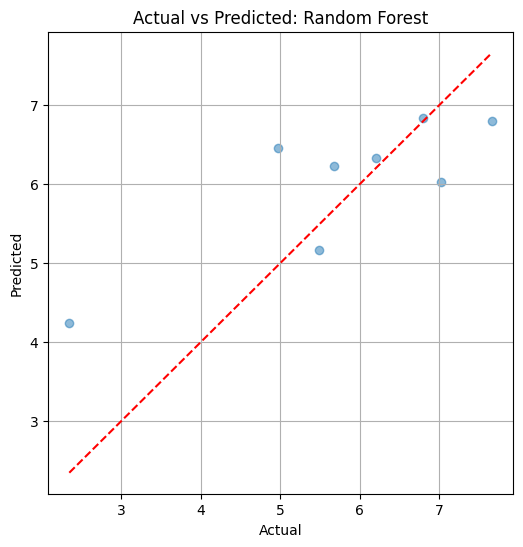

In [ ]:
best_model = models['Random Forest']
y_pred = best_model.predict(X_test)

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted: Random Forest")
plt.grid(True)
plt.show()


Switch log_subscriber_growth_rate and log_view_count

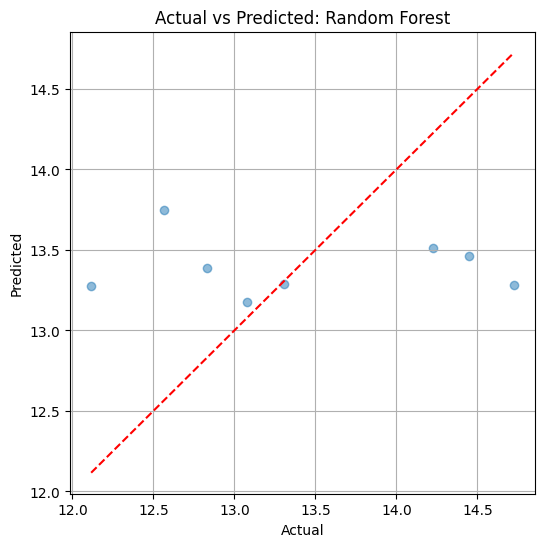

In [ ]:
best_model = models['Random Forest']
y_pred = best_model.predict(X_test)

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted: Random Forest")
plt.grid(True)
plt.show()

In [ ]:
# Save the DataFrame to CSV
df.to_csv("youtube_cleaned.csv", index=False)

In [ ]:
# Confirm the file was saved
import os
print("youtube_cleaned.csv" in os.listdir())  # Should return True


True


In [ ]:
from google.colab import files
files.download("youtube_cleaned.csv")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>